## Setup

In [1]:
import sys
sys.path.append('../')
del sys
%reload_ext autoreload
%autoreload 2

In [2]:
from modeling.pipeline import Pipeline
from modeling.nn import RegressionMLP, ClassificationMLP
import torch

## Data pipeline parameters

In [3]:
batch_size = 64
drop_last = False
test_proportion = 0.2
valid_proportion = 0.2
use_k_fold = False
k_k_fold = None

## Load the data

In [4]:
pipeline = Pipeline(use_k_fold=use_k_fold)
pipeline.process_data(batch_size=batch_size,
                      drop_last=drop_last,
                      test_proportion=test_proportion,
                      valid_proportion=valid_proportion,
                      k=k_k_fold)

Processing the modeling task...
Computing the annotated queries...
Initial length of queries: 0
Object loaded from ../results/../results/task_annotation/v2_0/task/queries_size10k_shuffle_articles1_queries1_seed0.pkl
Object loaded from ../results/../results/task_annotation/v2_1/task/queries_sizemax_shuffle_articles1_queries1_seed0.pkl
Object loaded from ../results/../results/task_annotation/v2_2/task/queries_sizemax_shuffle_articles1_queries1_seed0.pkl
Final length of queries: 61056
Done (elapsed time: 1s).

Computing the annotations...
Initial length of annotations: 0
Object loaded from ../results/task_annotation/v2_0/results/batch_00_complete.csv
   Correcting "n this article, Nevada and Ohio are discussed. The two American states..." to " The two American states..."
   Correcting "In this article, California and Oregon are discussed. The two neighboring states..." to " The two neighboring states..."
   Correcting "In this article, California and Oregon are discussed. The two West Coa

## Parameters

In [41]:
n_updates = 200
n_epochs = 3

## Metrics

In [7]:
scores_names = [
    'average_precision', 
    'precision_at_k', 
    'recall_at_k', 
    'reciprocal_best_rank', 
    'reciprocal_average_rank', 
    'ndcg'
]
is_regression = False

In [8]:
weight = torch.tensor([1, 1], dtype=torch.float)
loss = torch.nn.MSELoss() if is_regression else torch.nn.CrossEntropyLoss(weight=weight)

### BOW

In [10]:
input_dim, hidden_dim1, hidden_dim2 = 4310, 1000, 100
dropout = 0.1
lr = 1e-7

if is_regression:
    net = RegressionMLP(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, dropout=dropout)
else:
    net = ClassificationMLP(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, dropout=dropout)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [12]:
from modeling.models import BOWModel

model = BOWModel(min_vocab_frequency=100, net=net, optimizer=optimizer, loss=loss, scores_names=scores_names)
pipeline.preview_data(model=model, include_valid=False)

Learning the vocabulary...



Input size: 4310


In [42]:
pipeline.train_model(model=model, 
                     n_epochs=n_epochs, 
                     n_updates=n_updates,
                     is_regression=is_regression)

Training of the model...




--------------------------------------------------------------



Epoch 1/3: Validation Loss: 0.31860 Validation Score: 0.10899
--------------------------------------------------------------



Epoch 2/3: Validation Loss: 0.31845 Validation Score: 0.10620
--------------------------------------------------------------



Epoch 3/3: Validation Loss: 0.31820 Validation Score: 0.11527
--------------------------------------------------------------


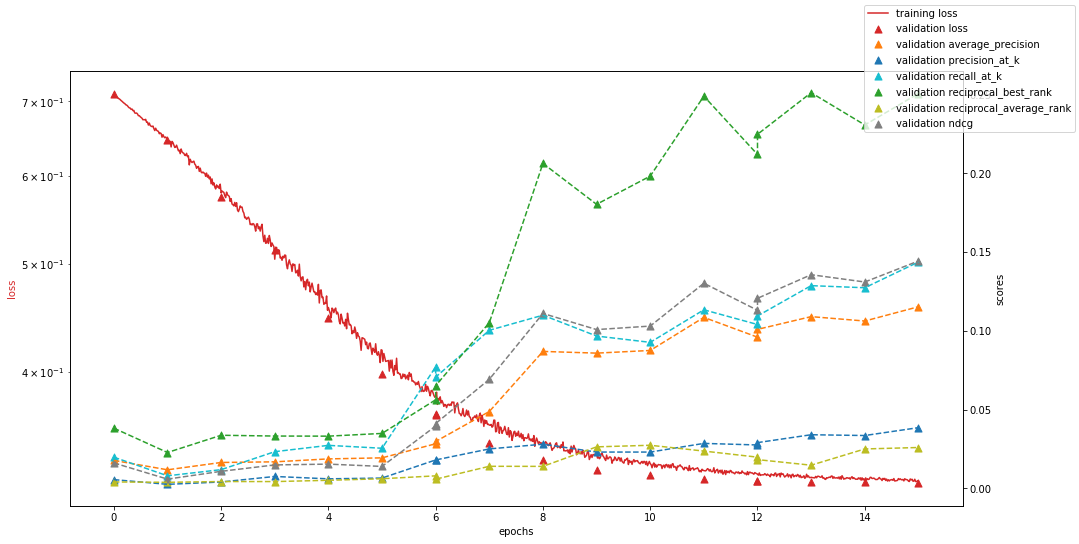

In [64]:
model.plot_metrics(scores_names=[
    'average_precision', 
    'precision_at_k', 
    'recall_at_k', 
    'reciprocal_best_rank', 
    'reciprocal_average_rank', 
    'ndcg'
],
                   align_experiments=True,
                  display_training_scores=False)

In [65]:
model.display_metrics()

average_precision: training set 0.07912 validation set 0.10784
precision_at_k: training set 0.01826 validation set 0.03375
recall_at_k: training set 0.16429 validation set 0.12727
best_rank: training set 29.97234 validation set 123.44875
average_rank: training set 31.09322 validation set 278.27473
reciprocal_best_rank: training set 0.08254 validation set 0.23932
reciprocal_average_rank: training set 0.07377 validation set 0.02093
ndcg: training set nan validation set 0.13289


In [66]:
model.net

ClassificationMLP(
  (dropout): Dropout(p=0.1, inplace=False)
  (input_layer): Linear(in_features=4310, out_features=1000, bias=True)
  (input_activation): ReLU()
  (hidden_layer): Linear(in_features=1000, out_features=100, bias=True)
  (hidden_activation): ReLU()
  (output_layer): Linear(in_features=100, out_features=2, bias=True)
  (output_activation): Softmax(dim=1)
)